# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os

import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

############# Chris added ###################
import skimage.color
import skimage.io
import skimage.transform

from sklearn.model_selection import train_test_split
import tensorflow
#############################################

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def IoU(x,y):
    '''
    version of IoU that uses np.bincount to get the value counts
    
    x and y are both numpy N x M masks
    
    x = proposed mask
    y = ground truth mask
    
    0 for a pixel indicates the mask is blocked, 1 indicates the mask is not blocked.
    In plain English, everywhere that is 1 we can see the cell, everywhere that is 0 we cannot.
    
    We want to calculate the IoU statistic, which is intersection(x,y)/union(x,y) at values where x or y is 1 
    
    By subtracting the proposed mask from 2 x the ground truth mask (i.e. blocked is 0, not blocked is 2),
    then adding 1, we get unique values for each type of overlap situation, plus all values are positive, which
    is required to use np.bincount:
    
INDX  0  1  2  3  4  5  6  7  8  9 10 11

GT    0  0  0  2  2  2  2  2  0  0  0  0
MSK - 0  0  1  1  1  1  0  1  1  0  0  0  
      ----------------------------------
      0  0 -1  1  1  1  2  1 -1  0  0  0
    + 1  1  1  1  1  1  1  1  1  1  1  1
      ----------------------------------
      1  1  0  2  2  2  3  2  0  1  1  1
      
    0: the proposed mask had a pixel, ground truth did not (include in union)   
    1: neither mask had a pixel (don't include)
    2: the proposed mask had a pixed, the ground truth had a pixel (include in intersection and union)
    3: the proposed mask did not have a pixel, the ground truth did (include in union)
    
    np.bincount always has length of np.amax(x) + 1, so we just need to do length checking
    '''
    x = x
    y = y * 2
    
    diff = np.bincount((y - x + 1).flatten())
    diff_len = len(diff)
    
    ### Cacluate the intersection first
    intersection = 0
    if (diff_len >= 3):
        intersection = diff[2]
    
    ### Now calculate the union
    union = intersection
    if diff_len == 4:
        union += diff[3]
    union += diff[0]
        
    if union==0:
        iou = 0 ### default value, we could potentially return blank masks, although GT should never be empty
    else:
        iou = float(intersection) / union
    
#     ### This is the code without error checking, basically doesn't speed it up at all
#     intersection = diff[2]
#     union = diff[0] + diff[2] + diff[3]
#     iou = float(intersection) / union

    return iou

def calc_IoU_matrix(gt_masks, pred_masks):
    '''
    Calculates the IoU matrix without thresholding. For increased speed, we could play some tricks based
    on the knowledge that 0.5 is the minimum threshold, but for now leaving out.
    
    Shape of gt_masks and pred_masks should be (num_masks, mask_x, mask_y)
    
    Returns a matrix with rows corresponding to ground truth masks, and columns predicted masks.
    '''
    ioumat = np.zeros((len(gt_masks),len(pred_masks)))
    for i in range(len(gt_masks)):
        for j in range(len(pred_masks)):
            ioumat[i,j] = IoU(pred_masks[j],gt_masks[i])
            
    return ioumat

def calc_precision(ioumat):
    '''
    Calculates the precision for a matrix that has already been thresholded.
    
    Assumes the minimum threshold is 0.5, i.e. all values <= 0.5 are eliminated. This helps
    us make some simplifying assumptions.
    '''
    ### First sum across the columns for each ground truth mask
    matsum = ioumat.sum(axis=1)
    
    true_pos = len(matsum[matsum > 0.0])
    false_neg = len(matsum[matsum == 0.0])
    false_pos = ioumat.shape[1] - true_pos
    
    precision = float(true_pos) / (true_pos + false_neg + false_pos)
    
    return precision#, true_pos, false_neg, false_pos

def calc_precisions(gt_masks, pred_masks, thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]):
    ### First calculate the IoU matrix
    ioumat = calc_IoU_matrix(gt_masks, pred_masks)
    
    precisions = []
    for threshold in thresholds:
        ioumat[ioumat <= threshold] = 0.0
        
        precisions.append(calc_precision(ioumat))
        
    return precisions

def calc_average_precision(gt_masks, pred_masks, thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]):
    precisions = np.array(calc_precisions(gt_masks, pred_masks, thresholds))
    return precisions.mean()

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5460302426214455385, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7785263924
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15489040997851774265
 physical_device_desc: "device: 0, name: Quadro P4000, pci bus id: 0000:00:05.0, compute capability: 6.1"]

In [4]:
### This just gets rid of any problem files that MacOSX tends to put in for its own book keeping
def filter_directory_list(directorylisting):
    if '.DS_Store' in directorylisting:
        directorylisting.remove('.DS_Store')
    return directorylisting

### Support function to grab the dimensions of an image or mask
def get_image_dim(image_path):
    return skimage.io.imread(image_path).shape

## Configurations

In [5]:
class SaltConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
#     IMAGES_PER_GPU = 256
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 64

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = SaltConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

## Notebook Preferences

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
class SaltDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    def __init__(self, class_map=None):
        self._image_ids = []
        self.image_info = []
        # Background is always the first class
        self.class_info = [{"source": "", "id": 0, "name": "BG"}]
        self.source_class_ids = {}
        
    def add_mask(self, source, image_id, path, **kwargs):
        self.image_info[image_id]["mask_path"] = path
        
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        ### Resize the image and save the modifications to image_info ###
        image, window, scale, padding, crop = utils.resize_image(image, max_dim=128, mode="square")
        self.image_info[image_id]["window"] = window
        self.image_info[image_id]["scale"] = scale
        self.image_info[image_id]["padding"] = padding
        self.image_info[image_id]["crop"] = crop
        return image
    
    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. Override this
        method to load instance masks and return them in the form of am
        array of binary masks of shape [height, width, instances].
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        mask = skimage.io.imread(self.image_info[image_id]['mask_path'])
        mask = mask.reshape(mask.shape[0],mask.shape[1],1)
        ### Extract how the original image was rescaled to do same to mask ###
        scale = self.image_info[image_id]["scale"]
        padding = self.image_info[image_id]["padding"]
        crop = self.image_info[image_id]["crop"]
        ### Resize the mask ###
        mask = utils.resize_mask(mask, scale, padding, crop=None)
        class_ids = np.array([1])
        return mask.astype(np.bool), class_ids

## Dataset

Load in the training images that make sense, i.e. they are not blank. These will not help in training, at least I don't think. We can double check in terms of whether they help train the system to not center on the borders.

In [8]:
### Load in the whole list then eliminate those that are bad ###
traindir = '../../train/'
all_image_files = np.array(os.listdir(filter_directory_list(traindir + 'images/')))

### Find out which images are blanks, eliminate them from the training set list ###
image_sums = np.array([skimage.io.imread(traindir + 'images/' + x).sum() for x in all_image_files])
good_training_images = np.argwhere(image_sums > 1000).reshape(-1)

print(len(all_image_files))
all_image_files = all_image_files[good_training_images]
print(len(all_image_files))

images_train = SaltDataset()
images_test = SaltDataset()

images_train.add_class("seismic",1,"salt")
images_test.add_class("seismic",1,"salt")

train_image_files, test_image_files = train_test_split(all_image_files, test_size=0.2, random_state=42)

for i in range(len(train_image_files)):
    images_train.add_image("seismic", i, traindir + 'images/' + train_image_files[i])
    images_train.add_mask("seismic", i, traindir + 'masks/' + train_image_files[i])

for i in range(len(test_image_files)):
    images_test.add_image("seismic", i, traindir + 'images/' + test_image_files[i])
    images_test.add_mask("seismic", i, traindir + 'masks/' + test_image_files[i])

images_train.prepare()
images_test.prepare()

4000
3920


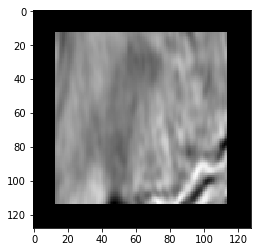

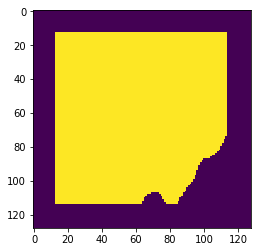

In [9]:
plt.imshow(images_train.load_image(6)); plt.show()
plt.imshow(images_train.load_mask(6)[0][:,:,0]); plt.show()

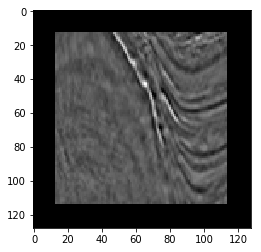

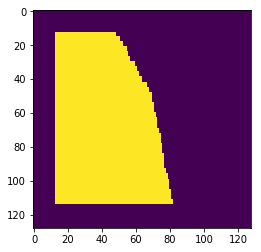

In [10]:
plt.imshow(images_test.load_image(1)); plt.show()
plt.imshow(images_test.load_mask(1)[0][:,:,0]); plt.show()

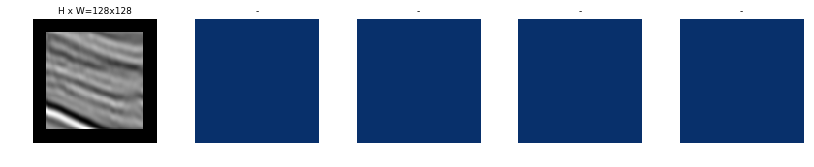

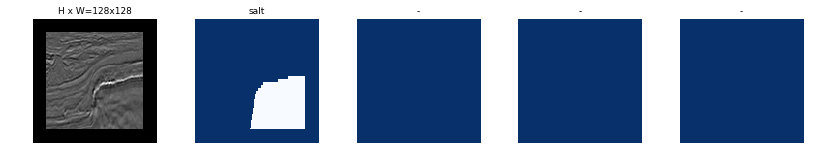

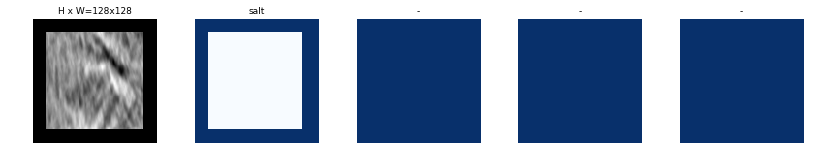

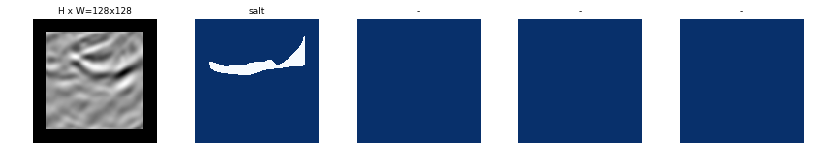

In [11]:
# Load and display random samples
image_ids = np.random.choice(images_train.image_ids, 4)
for image_id in image_ids:
    image = images_train.load_image(image_id)
    mask, class_ids = images_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, images_train.class_names)

## Ceate Model, Train from Scratch with 5+

64 ROIs. The original trial had 32.

In [12]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [13]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train with 5+ for 100 epochs.

In [14]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(images_train, images_test, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100, 
            layers='5+')

Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/paperspace/Documents/kaggle/salt/kaggle_salt/notebooks/logs/shapes20180808T1308/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
res5a_branch2a         (Conv2D)
bn5a_branch2a          (BatchNorm)
res5a_branch2b         (Conv2D)
bn5a_branch2b          (BatchNorm)
res5a_branch2c         (Conv2D)
res5a_branch1          (Conv2D)
bn5a_branch2c          (BatchNorm)
bn5a_branch1           (BatchNorm)
res5b_branch2a         (Conv2D)
bn5b_branch2a          (BatchNorm)
res5b_branch2b         (Conv2D)
bn5b_branch2b          (BatchNorm)
res5b_branch2c         (Conv2D)
bn5b_branch2c          (BatchNorm)
res5c_branch2a         (Conv2D)
bn5c_branch2a          (BatchNorm)
res5c_branch2b         (Conv2D)
bn5c_branch2b          (BatchNorm)
res5c_branch2c         (Conv2D)
bn5c_branch2c          (BatchNorm)
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)


/home/paperspace/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 2.3567 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 1.2282 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.4156 - mrcnn_mask_loss: 0.6044

/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 90s 900ms/step - loss: 2.3451 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 1.2217 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.4137 - mrcnn_mask_loss: 0.6018 - val_loss: 1.3540 - val_rpn_class_loss: 0.0193 - val_rpn_bbox_loss: 0.5479 - val_mrcnn_class_loss: 0.0322 - val_mrcnn_bbox_loss: 0.2563 - val_mrcnn_mask_loss: 0.4983
Epoch 2/100
100/100 [==============================] - 70s 697ms/step - loss: 1.4690 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.7361 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.2658 - mrcnn_mask_loss: 0.4187 - val_loss: 1.1214 - val_rpn_class_loss: 0.0143 - val_rpn_bbox_loss: 0.4046 - val_mrcnn_class_loss: 0.0353 - val_mrcnn_bbox_loss: 0.2692 - val_mrcnn_mask_loss: 0.3980
Epoch 3/100
100/100 [==============================] - 70s 698ms/step - loss: 1.2930 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.6273 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.2474 - mrcnn_mask_loss: 0.3742 - val_loss: 1.2612 - val_rpn_class_loss

Epoch 23/100
100/100 [==============================] - 69s 693ms/step - loss: 0.5773 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2267 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.1386 - mrcnn_mask_loss: 0.1765 - val_loss: 1.0218 - val_rpn_class_loss: 0.0101 - val_rpn_bbox_loss: 0.5557 - val_mrcnn_class_loss: 0.0297 - val_mrcnn_bbox_loss: 0.2088 - val_mrcnn_mask_loss: 0.2175
Epoch 24/100
100/100 [==============================] - 70s 698ms/step - loss: 0.5202 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2047 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.1621 - val_loss: 0.6937 - val_rpn_class_loss: 0.0073 - val_rpn_bbox_loss: 0.2916 - val_mrcnn_class_loss: 0.0261 - val_mrcnn_bbox_loss: 0.1704 - val_mrcnn_mask_loss: 0.1982
Epoch 25/100
100/100 [==============================] - 70s 697ms/step - loss: 0.5433 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2079 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.1364 - mrcnn_mask_loss: 0.1704 - val_loss: 1.3289 - val

100/100 [==============================] - 68s 677ms/step - loss: 0.2685 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1193 - val_loss: 0.7103 - val_rpn_class_loss: 0.0046 - val_rpn_bbox_loss: 0.3001 - val_mrcnn_class_loss: 0.0303 - val_mrcnn_bbox_loss: 0.1516 - val_mrcnn_mask_loss: 0.2236
Epoch 66/100
100/100 [==============================] - 68s 676ms/step - loss: 0.2486 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0577 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1132 - val_loss: 0.7546 - val_rpn_class_loss: 0.0043 - val_rpn_bbox_loss: 0.3037 - val_mrcnn_class_loss: 0.0302 - val_mrcnn_bbox_loss: 0.2171 - val_mrcnn_mask_loss: 0.1992
Epoch 67/100
100/100 [==============================] - 67s 675ms/step - loss: 0.2646 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0741 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0562 - mrcnn_mask_loss: 0.1136 - val_loss: 0.8091 - val_rpn_class_lo

In [15]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
CURR_MODEL_NAME = "mask_rcnn_salt_5_plus_ROIS_64_epochs_100.h5"
model_path = os.path.join(MODEL_DIR, CURR_MODEL_NAME)
model.keras_model.save_weights(model_path)

Model broke during later iterations, the intermediate model output filled paperspace storage super fast.

In [16]:
os.system("rm -r logs/shape*")

0

## Detection

In [17]:
CURR_MODEL_NAME = "mask_rcnn_salt_5_plus_ROIS_64_epochs_100.h5"

class InferenceConfig(SaltConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()
model_path = os.path.join(MODEL_DIR, CURR_MODEL_NAME)


# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/paperspace/Documents/kaggle/salt/kaggle_salt/notebooks/logs/mask_rcnn_salt_5_plus_ROIS_64_epochs_100.h5


original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  631.00000  int64


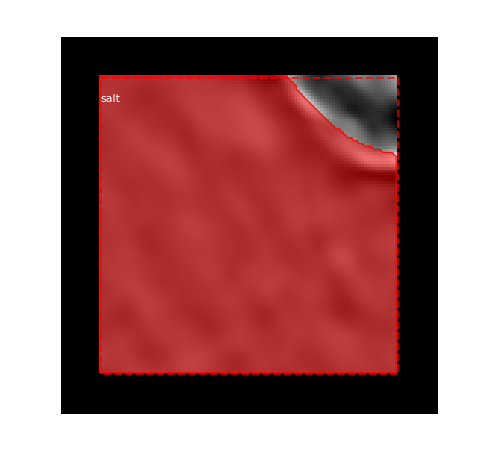

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


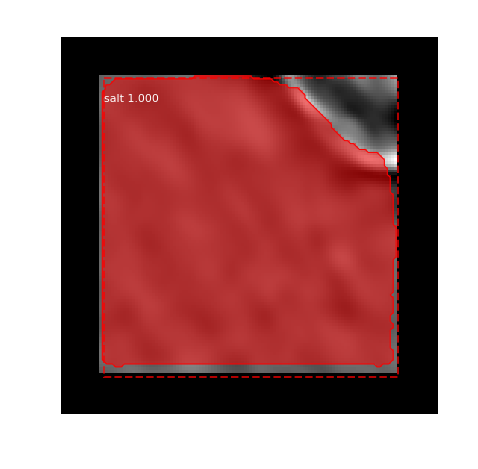

In [30]:
# Test on a random image
image_id = random.choice(images_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(images_test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            images_test.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            images_test.class_names, r['scores'], ax=get_ax())

## Evaluation

In [31]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
# iou_thresholds = [0.5]
image_ids = images_test.image_ids
# image_ids = np.random.choice(images_test.image_ids, 10)
# image_ids = np.random.choice(images_test.image_ids, 1)

APs = []
for image_id in image_ids:
    print(image_id)
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(images_test, inference_config,
                               image_id, use_mini_mask=False)
    
    if gt_class_id.shape[0]!=0:
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        pred_masks = np.array([r['masks'][:,:,i] for i in range(r['masks'].shape[2])]).astype('int')
        ### Calculate the array of ground truth masks
        gt_masks = np.array([gt_mask[:,:,i] for i in range(gt_mask.shape[2])]).astype('int')
        
        AP = calc_average_precision(gt_masks, pred_masks, thresholds=iou_thresholds)
#         pred_masks = r['masks']
#         curr_APs = []
#         for iou_threshold in iou_thresholds:
#             # Compute AP
#             AP, precisions, recalls, overlaps =\
#                 utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                                  r["rois"], r["class_ids"], r["scores"], r['masks'])
#             curr_APs.append(AP)
#         print(AP)
        APs.append(AP)
#         precs.append(precisions)
print("mAP: ", np.mean(APs))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Try threshold tuning using my IoU metric

In [14]:
CURR_MODEL_NAME = "mask_rcnn_salt_4_plus_epochs_100.h5"

det_min_confidences = np.arange(0.0, 1.05, 0.05)
det_nms_thresholds = np.arange(0.0, 1.05, 0.05).astype(np.float32)

mAP = []
for det_nms_threshold in det_nms_thresholds:
    print("Current threshold:",det_nms_threshold)
    
    class InferenceConfig(SaltConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1

        # Minimum probability value to accept a detected instance
        # ROIs below this threshold are skipped
        DETECTION_MIN_CONFIDENCE = 0.8
        
        # Non-maximum suppression threshold for detection
        DETECTION_NMS_THRESHOLD = det_nms_threshold.astype(np.float32)
        

    inference_config = InferenceConfig()

    # Recreate the model in inference mode
    model = modellib.MaskRCNN(mode="inference", 
                              config=inference_config,
                              model_dir=MODEL_DIR)

    # Get path to saved weights
    # Either set a specific path or find last trained weights
    # model_path = os.path.join(ROOT_DIR, ".h5 file name here")
    # model_path = model.find_last()
    model_path = os.path.join(MODEL_DIR, CURR_MODEL_NAME)


    # Load trained weights
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)
    
    ### Do the calculation of the mAP
    iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    image_ids = images_test.image_ids

    APs = []
    for image_id in image_ids:
#         print(image_id)
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(images_test, inference_config,
                                   image_id, use_mini_mask=False)

        if gt_class_id.shape[0]!=0:
            molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
            # Run object detection
            results = model.detect([image], verbose=0)
            r = results[0]
            pred_masks = np.array([r['masks'][:,:,i] for i in range(r['masks'].shape[2])]).astype('int')
            ### Calculate the array of ground truth masks
            gt_masks = np.array([gt_mask[:,:,i] for i in range(gt_mask.shape[2])]).astype('int')

            AP = calc_average_precision(gt_masks, pred_masks, thresholds=iou_thresholds)
            APs.append(AP)
    #         precs.append(precisions)
    print("mAP: ", np.mean(APs))
    mAP.append(np.mean(APs))

Current threshold: 0.0
Loading weights from  /home/paperspace/Documents/kaggle/salt/kaggle_salt/notebooks/logs/mask_rcnn_salt_4_plus_epochs_100.h5
mAP:  0.6047337278106509
Current threshold: 0.05
Loading weights from  /home/paperspace/Documents/kaggle/salt/kaggle_salt/notebooks/logs/mask_rcnn_salt_4_plus_epochs_100.h5
mAP:  0.6002958579881658
Current threshold: 0.1
Loading weights from  /home/paperspace/Documents/kaggle/salt/kaggle_salt/notebooks/logs/mask_rcnn_salt_4_plus_epochs_100.h5
mAP:  0.5996055226824457
Current threshold: 0.15
Loading weights from  /home/paperspace/Documents/kaggle/salt/kaggle_salt/notebooks/logs/mask_rcnn_salt_4_plus_epochs_100.h5
mAP:  0.5995069033530572
Current threshold: 0.2
Loading weights from  /home/paperspace/Documents/kaggle/salt/kaggle_salt/notebooks/logs/mask_rcnn_salt_4_plus_epochs_100.h5
mAP:  0.5994411571334648
Current threshold: 0.25
Loading weights from  /home/paperspace/Documents/kaggle/salt/kaggle_salt/notebooks/logs/mask_rcnn_salt_4_plus_epoc

(0.575, 0.61)

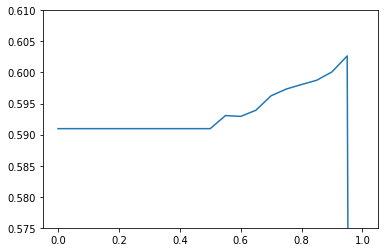

In [26]:
plt.plot(np.arange(0.0, 1.05, 0.05), mAP); plt.ylim([0.575,0.61])

In [28]:
import pandas as pd

In [31]:
outdf = pd.DataFrame([np.arange(0.0, 1.05, 0.05), mAP]).T

In [32]:
outdf.columns = ['det_min_confidence', 'mAP']

In [33]:
outdf.to_csv('./det_min_confidence_tuning.csv')

(0.575, 0.62)

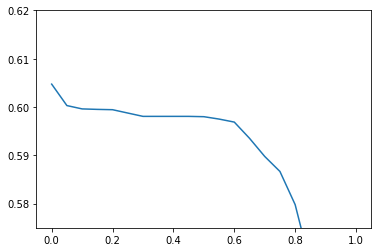

In [17]:
plt.plot(det_nms_thresholds, mAP); plt.ylim([0.575,0.62])

### Older code

In [83]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
iou_thresholds = [0.5, 0.55]#, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
iou_thresholds = [0.5]
# image_ids = images_test.image_ids#np.random.choice(images_test.image_ids, 10)
image_ids = np.random.choice(images_test.image_ids, 10)
APs = []
precs = []
for image_id in image_ids:
    print(image_id)
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(images_test, inference_config,
                               image_id, use_mini_mask=False)
    if gt_class_id.shape[0]!=0:
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        curr_APs = []
        for iou_threshold in iou_thresholds:
            # Compute AP
            AP, precisions, recalls, overlaps =\
                utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                 r["rois"], r["class_ids"], r["scores"], r['masks'])
            curr_APs.append(AP)
        APs.append(curr_APs)
        precs.append(precisions)
# print("mAP: ", np.mean(APs))

375
298
74
759
180
256
731
289
577
750


In [84]:
r['masks'].shape

(128, 128, 4)

In [86]:
precs

[array([1.        , 1.        , 0.5       , 0.33333333, 0.        ]),
 array([1.        , 1.        , 0.5       , 0.33333333, 0.        ]),
 array([1.        , 1.        , 0.5       , 0.33333333, 0.25      ,
        0.2       , 0.        ]),
 array([0., 0., 0., 0., 0., 0.]),
 array([1.        , 1.        , 0.5       , 0.33333333, 0.25      ,
        0.        ])]

In [87]:
APs

[[1.0], [1.0], [1.0], [0.0], [1.0]]

In [52]:
import pandas as pd

In [53]:
pd.DataFrame(APs)

,0,1
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
5,0.0,0.0
6,0.5,0.5


In [50]:
counter = 0
for image_id in image_ids:
#     print(image_id)
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(images_test, inference_config,
                                   image_id, use_mini_mask=False)
    print(gt_class_id.shape)
    
    if gt_class_id.shape[0]!=0:
        counter += 1
print(counter)

(0,)
(1,)
(1,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(0,)
(1,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(0,)
(1,)
(1,)
(0,)
(1,)
(1,)
(1,)
(1,)
(1,)
(0,)
(0,)
(1,)
(0,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(0,)
(1,)
(1,)
(0,)
(1,)
(1,)
(1,)
(0,)
(0,)
(0,)
(1,)
(0,)
(1,)
(1,)
(1,)
(0,)
(1,)
(1,)
(1,)
(1,)
(0,)
(1,)
(0,)
(1,)
(0,)
(1,)
(0,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(0,)
(0,)
(0,)
(0,)
(1,)
(0,)
(0,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(0,)
(0,)
(1,)
(0,)
(0,)
(1,)
(1,)
(1,)
(1,)
(1,)
(0,)
(1,)
(1,)
(1,)
(0,)
(1,)
(0,)
(1,)
(0,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(0,)
(1,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(1,)
(1,)
(0,)
(1,)
(0,)
(1,)
(1,)
(0,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(0,)
(1,)
(1,)
(0,)
(1,)
(0,)
(1,)
(1,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(1,)
(1,)
(0,)
(0,)
(1,)
(0,)
(0,)
(1,)
(0,)
(1,)
(1,)
(1,)
(1,)
(0,)
(1,)
(1,)
(0,)
(1,)
(1,)
(1,)
(0,)
(0,)
(1,)
(1,)
(0,)
(1,)
(0,)
(1,)
(0,)
(0,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)
(1,)


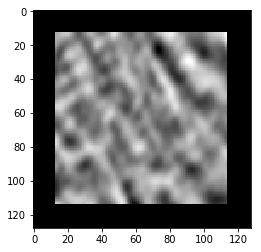

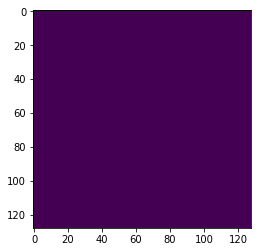

In [266]:
plt.imshow(images_test.load_image(496));plt.show()
plt.imshow(images_test.load_mask(496)[0][:,:,0]);plt.show()

So this occurs when we have an image that has no ground truth bounding box to ignore. For now let's just not worry about these. May need to look at the scoring to see how they are dealt with in general.

In [267]:
image_id = 496
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(images_test, inference_config,
                               image_id, use_mini_mask=False)

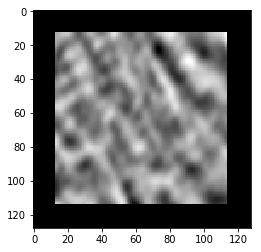

In [269]:
plt.imshow(image); plt.show()

In [270]:
image_meta

array([496, 128, 128,   3, 128, 128,   3,   0,   0, 128, 128,   1,   1,
         1])

In [271]:
gt_class_id

array([], dtype=int64)

In [273]:
gt_class_id.shape[0]

0

In [274]:
image_id = 797
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(images_test, inference_config,
                               image_id, use_mini_mask=False)

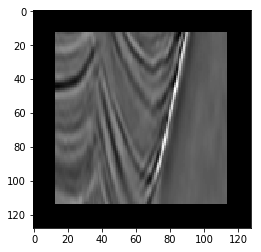

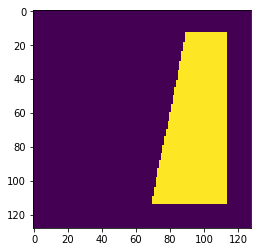

In [282]:
plt.imshow(image); plt.show()
plt.imshow(gt_mask[:,:,0]); plt.show()

In [284]:
gt_class_id.shape[0]

1

In [277]:
gt_bbox

array([[ 13,  70, 114, 114]], dtype=int32)

In [106]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
iou_thresholds = [0.5, 0.55]#, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
# iou_thresholds = [0.5]
# image_ids = images_test.image_ids#np.random.choice(images_test.image_ids, 10)
# image_ids = np.random.choice(images_test.image_ids, 10)
image_ids = np.random.choice(images_test.image_ids, 1)

for image_id in image_ids:
    print(image_id)
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(images_test, inference_config,
                               image_id, use_mini_mask=False)
        
    if gt_class_id.shape[0]!=0:
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
#         pred_masks = r['masks']
#         curr_APs = []
#         for iou_threshold in iou_thresholds:
#             # Compute AP
#             AP, precisions, recalls, overlaps =\
#                 utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                                  r["rois"], r["class_ids"], r["scores"], r['masks'])
#             curr_APs.append(AP)
#         APs.append(curr_APs)
#         precs.append(precisions)
# print("mAP: ", np.mean(APs))

257


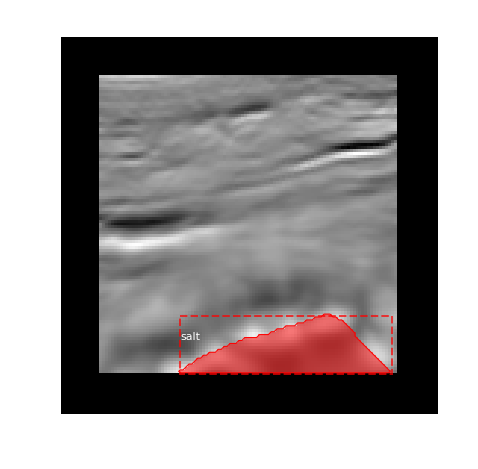

In [107]:
visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            images_test.class_names, figsize=(8, 8))

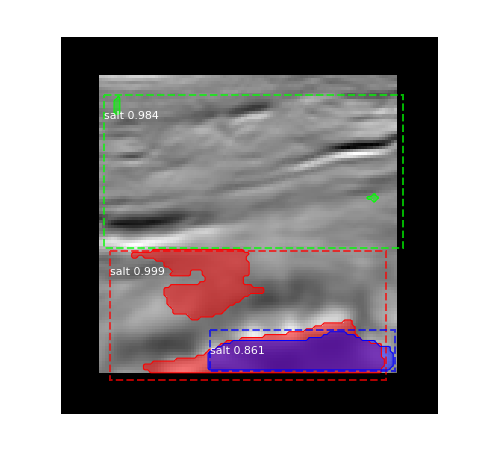

In [108]:
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            images_test.class_names, r['scores'], ax=get_ax())

In [110]:
r['masks'].shape

(128, 128, 3)

In [112]:
gt_mask.shape

(128, 128, 1)

In [121]:
pred_masks = np.array([r['masks'][:,:,i] for i in range(r['masks'].shape[2])]).astype('int')

In [122]:
pred_masks.shape

(3, 128, 128)

In [123]:
gt_masks = np.array([gt_mask[:,:,i] for i in range(gt_mask.shape[2])]).astype('int')

In [127]:
calc_precisions(gt_masks, pred_masks, thresholds=[0.5])

[0.3333333333333333]